# Note: This notebook is quoted for reference from kaggle.com, not owned by me

In [ ]:
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df_data = pd.read_csv("/kaggle/input/vietnam-weather-data/weather.csv")
df_data.head()

,province,max,min,wind,wind_d,rain,humidi,cloud,pressure,date
0,Bac Lieu,27,22,17,NNE,6.9,90,71,1010,2009-01-01
1,Bac Lieu,31,25,20,ENE,0.0,64,24,1010,2010-01-01
2,Bac Lieu,29,24,14,E,0.0,75,45,1008,2011-01-01
3,Bac Lieu,30,24,30,E,0.0,79,52,1012,2012-01-01
4,Bac Lieu,31,25,20,ENE,0.0,70,24,1010,2013-01-01


In [ ]:
province = "Bac Lieu"
df_data = df_data[df_data['province'] == 'Bac Lieu']

In [ ]:
import datetime

# Sort by date value
day_values = []
for d in df_data['date']:
    year = d.split('-')[0]
    month = d.split('-')[1]
    day = d.split('-')[2]
    date = datetime.datetime(int(year), int(month), int(day))
    day_value = (date - datetime.datetime(2009, 1, 1)).days
    day_values.append(day_value)
df_data['day_value'] = day_values
df_data = df_data.sort_values(by=['day_value'], ascending=True)

years = []
for d in df_data['date']:
    years.append(d.split('-')[0])
df_data['year'] = years

year_months = []
cnt_week = 1
for d in df_data['date']:
    year_months.append('-'.join(d.split('-')[:2]))
df_data['year_month'] = year_months

year_month_weeks = []
cnt_week = 1
prev_month = df_data['date'][0].split('-')[1]
for d in df_data['date']:
    year = d.split('-')[0]
    month = d.split('-')[1]
    day = d.split('-')[2]
    date = datetime.datetime(int(year), int(month), int(day))
    year_month_week = year + "-" + month + "-" + str(cnt_week)
    year_month_weeks.append(year_month_week)
    if date.weekday() == 6:
        cnt_week += 1
    if prev_month != month:
        cnt_week = 1
        prev_month = month
df_data['year_month_week'] = year_month_weeks

df_data.head()

,province,max,min,wind,wind_d,rain,humidi,cloud,pressure,date,day_value,year,year_month,year_month_week
0,Bac Lieu,27,22,17,NNE,6.9,90,71,1010,2009-01-01,0,2009,2009-01,2009-01-1
117,Bac Lieu,28,22,15,ENE,0.5,85,61,1010,2009-01-02,1,2009,2009-01,2009-01-1
91,Bac Lieu,23,21,9,ESE,16.7,91,77,1011,2009-01-03,2,2009,2009-01,2009-01-1
104,Bac Lieu,27,21,9,E,2.2,86,32,1011,2009-01-04,3,2009,2009-01,2009-01-1
39,Bac Lieu,29,22,10,SE,0.0,81,25,1010,2009-01-05,4,2009,2009-01,2009-01-2


In [ ]:
df_data[["wind", "rain", "humidi", "cloud", "pressure"]].corr()

,wind,rain,humidi,cloud,pressure
wind,1.000000,-0.269365,-0.314555,-0.169690,0.238582
rain,-0.269365,1.000000,0.441293,0.359306,-0.302270
humidi,-0.314555,0.441293,1.000000,0.529574,-0.320158
cloud,-0.169690,0.359306,0.529574,1.000000,-0.337286
pressure,0.238582,-0.302270,-0.320158,-0.337286,1.000000


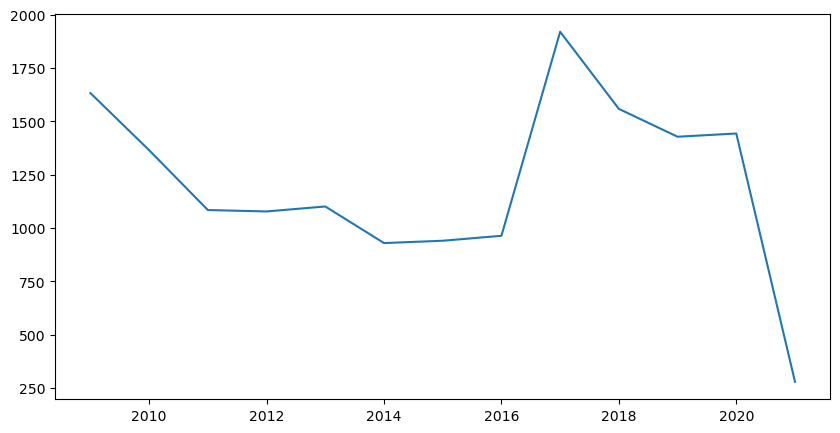

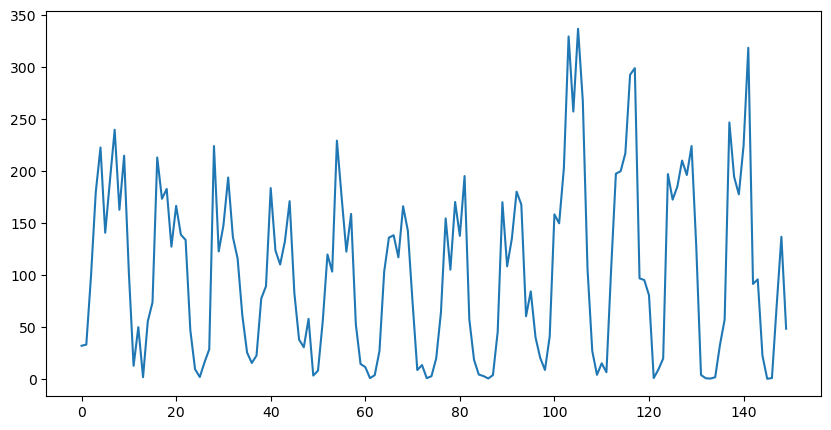

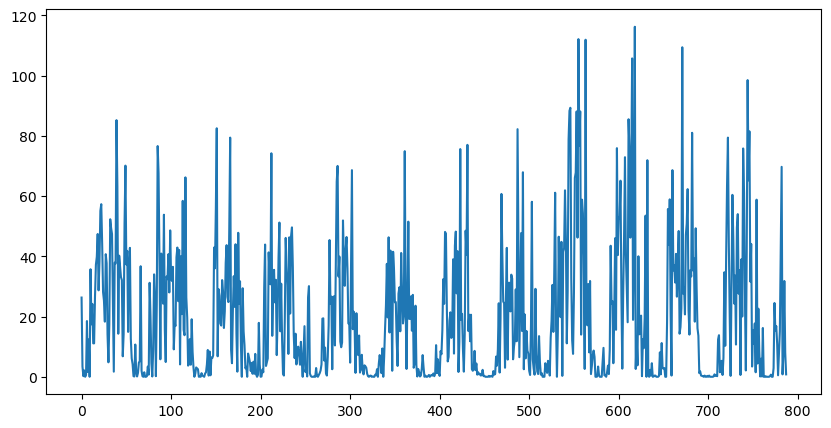

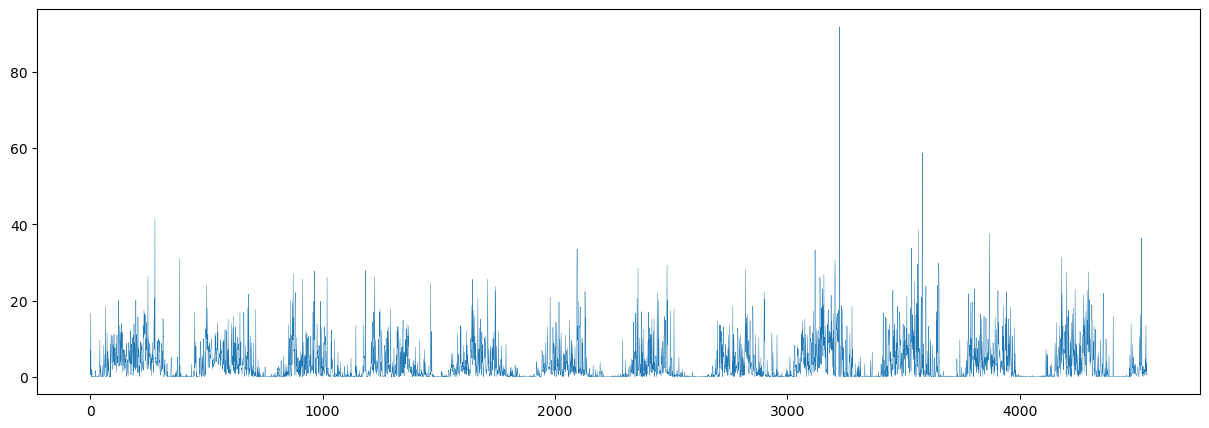

In [ ]:
# Yearly
rains = df_data.groupby(by="year")['rain'].sum()
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(range(2009, 2009 + len(rains)), rains)
plt.show()

# Monthly
rains = df_data.groupby(by="year_month")['rain'].sum()
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(range(len(rains)), rains)
plt.show()

# Weekly
rains = df_data.groupby(by="year_month_week")['rain'].sum()
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(range(len(rains)), rains)
plt.show()

# Daily
rains = df_data['rain']
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(range(len(rains)), rains, linewidth=0.3)
plt.show()

# ML Approach

## Data Preparation

In [ ]:
# Preprocessing data
df_data.head()

,province,max,min,wind,wind_d,rain,humidi,cloud,pressure,date,day_value,year,year_month,year_month_week
0,Bac Lieu,27,22,17,NNE,6.9,90,71,1010,2009-01-01,0,2009,2009-01,2009-01-1
117,Bac Lieu,28,22,15,ENE,0.5,85,61,1010,2009-01-02,1,2009,2009-01,2009-01-1
91,Bac Lieu,23,21,9,ESE,16.7,91,77,1011,2009-01-03,2,2009,2009-01,2009-01-1
104,Bac Lieu,27,21,9,E,2.2,86,32,1011,2009-01-04,3,2009,2009-01,2009-01-1
39,Bac Lieu,29,22,10,SE,0.0,81,25,1010,2009-01-05,4,2009,2009-01,2009-01-2


In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [ ]:
numeric_features = ['max', 'min', 'wind', 'humidi', 'cloud', 'pressure']
categorical_features = ['wind_d']
label = 'rain'

scalers = {}
encoders = {}

def get_feature_name_by_idx(idx):
    if idx < len(numeric_features):
        return numeric_features[idx]
    return 'wind_d' + ":" + str(encoders['wind_d'].categories_[0][idx - len(numeric_features)])

def scale_data(scalers, df, feature):
    data = np.array(df[feature].tolist()).reshape(-1, 1)
    scaler = MinMaxScaler().fit(data)
    scaled_data = scaler.transform(data)
    df[feature] = scaled_data
    scalers[feature] = scaler
    return scalers, df

def encode_data(encoders, df, feature):
    data = np.array(df[feature].tolist()).reshape(-1, 1)
    encoder = OneHotEncoder().fit(data)
    encoded_data = encoder.transform(data).toarray()
    df[feature] = list(encoded_data)
    encoders[feature] = encoder
    return encoders, df

df_processed = df_data.copy(deep=True)
for feature in numeric_features:
    scalers, df_processed = scale_data(scalers, df_processed, feature)
for feature in categorical_features:
    encoders, df_processed = encode_data(encoders, df_processed, feature)

df_processed.head()

,province,max,min,wind,wind_d,rain,humidi,cloud,pressure,date,day_value,year,year_month,year_month_week
0,Bac Lieu,0.294118,0.384615,0.411765,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",6.9,0.866667,0.717172,0.538462,2009-01-01,0,2009,2009-01,2009-01-1
117,Bac Lieu,0.352941,0.384615,0.352941,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.5,0.755556,0.616162,0.538462,2009-01-02,1,2009,2009-01,2009-01-1
91,Bac Lieu,0.058824,0.307692,0.176471,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16.7,0.888889,0.777778,0.615385,2009-01-03,2,2009,2009-01,2009-01-1
104,Bac Lieu,0.294118,0.307692,0.176471,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.2,0.777778,0.323232,0.615385,2009-01-04,3,2009,2009-01,2009-01-1
39,Bac Lieu,0.411765,0.384615,0.205882,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.666667,0.252525,0.538462,2009-01-05,4,2009,2009-01,2009-01-2


In [ ]:
X_train = []
y_train = []
for i in range(len(df_processed)):
    x = []
    for feature in numeric_features:
        x.append(df_processed[feature].tolist()[i])
    for feature in categorical_features:
        x.extend(df_processed[feature].tolist()[i])
    X_train.append(x)
    if df_processed[label].tolist()[i] > 0:
        y_train.append(1)
    else:
        y_train.append(0)
X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(4549, 22)
(4549,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train = np.array(X_train)
y_train = np.array(y_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=420)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4094, 22)
(4094,)
(455, 22)
(455,)


## Training

### XGBoost

In [ ]:
from xgboost import plot_importance, XGBClassifier
import xgboost as xgb


feature_names = []
for i in range(X_train.shape[1]):
    feature_names.append(get_feature_name_by_idx(i))

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, feature_names=feature_names, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, feature_names=feature_names, enable_categorical=True)
params = {"objective": "binary:logistic", "tree_method": "auto"}
n = 150
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]
model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    early_stopping_rounds=15,
    evals=evals,
)

[0]	train-logloss:0.52559	validation-logloss:0.53914
[1]	train-logloss:0.42552	validation-logloss:0.45275
[2]	train-logloss:0.36391	validation-logloss:0.40028
[3]	train-logloss:0.32130	validation-logloss:0.36890
[4]	train-logloss:0.29087	validation-logloss:0.35055
[5]	train-logloss:0.26778	validation-logloss:0.33659
[6]	train-logloss:0.25048	validation-logloss:0.33015
[7]	train-logloss:0.23889	validation-logloss:0.32441
[8]	train-logloss:0.22986	validation-logloss:0.32136
[9]	train-logloss:0.22346	validation-logloss:0.31777
[10]	train-logloss:0.21841	validation-logloss:0.31499
[11]	train-logloss:0.21292	validation-logloss:0.31379
[12]	train-logloss:0.20939	validation-logloss:0.31598
[13]	train-logloss:0.20690	validation-logloss:0.31486
[14]	train-logloss:0.20363	validation-logloss:0.31685
[15]	train-logloss:0.20117	validation-logloss:0.31700
[16]	train-logloss:0.19805	validation-logloss:0.31893
[17]	train-logloss:0.19675	validation-logloss:0.31969
[18]	train-logloss:0.19407	validation-

## Neural-based models: TabPFN

In [ ]:
!pip install tabpfn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.6/156.6 kB 6.7 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier


# N_ensemble_configurations controls the number of model predictions that are ensembled with feature and class rotations (See our work for details).
# When N_ensemble_configurations > #features * #classes, no further averaging is applied.

classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=32)

classifier.fit(X_train, y_train, overwrite_warning=True)
y_pred, p_eval = classifier.predict(X_test, return_winning_probability=True)

We have to download the TabPFN, as there is no checkpoint at  /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt
It has about 100MB, so this might take a moment.


Accuracy score: 0.8923076923076924
F-1 score: 0.9298998569384835


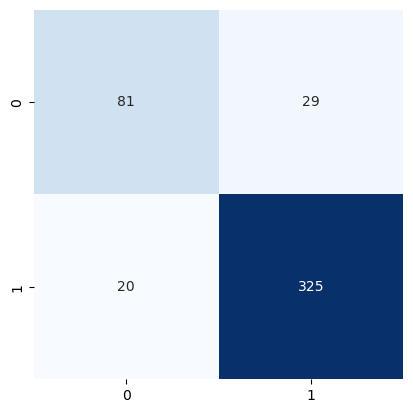

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)


print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"F-1 score: {f1_score(y_test, y_pred)}")

### Clustering

In [ ]:
from sklearn.cluster import KMeans

# cluster_movie_data = df_cluster_movie.to_numpy()
# print(cluster_movie_data.shape)

sse = {}

kmeans = KMeans(n_clusters=2, max_iter=1000, n_init='auto').fit(X_train)
print(kmeans.inertia_)

3323.1146216252196


In [ ]:
class MyCluster():
    def __init__(self, X_train, y_train, idx, centroid=None):
        self.X_train = X_train
        self.y_train = y_train
        self.idx = idx
        self.centroid = centroid
        self.label = None
        if sum(self.y_train) == 0:
            self.label = 0
        if sum(self.y_train) == len(self.y_train):
            self.label = 1
    def get_positive_ratio(self):
        return sum(self.y_train)/len(self.y_train)
    def __str__(self):
        n_pos = sum(self.y_train)
        return f"0: {len(self.y_train) - n_pos} - 1: {n_pos}"
    def is_single_class(self):
        return sum(self.y_train) == 0 or sum(self.y_train) == len(self.y_train)

cur_cluster_idx = 1
initial_cluster = MyCluster(X_train, y_train, 0)
multi_class_cluster = [initial_cluster]
single_class_cluster = []

while len(multi_class_cluster) > 0:
    cluster = multi_class_cluster.pop()

    kmeans = KMeans(n_clusters=2, max_iter=1000, n_init='auto').fit(cluster.X_train)

    idx_cluster0 = [i for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == 0]
    if len(idx_cluster0) > 0:
        X_train_cluster0 = X_train[idx_cluster0, :]
        y_train_cluster0 = y_train[idx_cluster0]
        cluster0 = MyCluster(X_train_cluster0, y_train_cluster0, cur_cluster_idx, kmeans.cluster_centers_[0])
        cur_cluster_idx += 1
        if cluster0.is_single_class():
            single_class_cluster.append(cluster0)
        else:
            multi_class_cluster.append(cluster0)

    idx_cluster1 = [i for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == 1]
    if len(idx_cluster1) > 0:
        X_train_cluster1 = X_train[idx_cluster1, :]
        y_train_cluster1 = y_train[idx_cluster1]
        cluster1 = MyCluster(X_train_cluster1, y_train_cluster1, cur_cluster_idx, kmeans.cluster_centers_[1])
        cur_cluster_idx += 1
        if cluster1.is_single_class():
            single_class_cluster.append(cluster1)
        else:
            multi_class_cluster.append(cluster1)

    print(f"n_single_cluster: {len(single_class_cluster)} - n_multi_cluster: {len(multi_class_cluster)}")


n_single_cluster: 0 - n_multi_cluster: 2
n_single_cluster: 0 - n_multi_cluster: 3
n_single_cluster: 0 - n_multi_cluster: 4
n_single_cluster: 0 - n_multi_cluster: 5
n_single_cluster: 0 - n_multi_cluster: 6
n_single_cluster: 1 - n_multi_cluster: 6
n_single_cluster: 1 - n_multi_cluster: 7
n_single_cluster: 2 - n_multi_cluster: 7
n_single_cluster: 3 - n_multi_cluster: 7
n_single_cluster: 4 - n_multi_cluster: 7
n_single_cluster: 6 - n_multi_cluster: 6
n_single_cluster: 8 - n_multi_cluster: 5
n_single_cluster: 9 - n_multi_cluster: 5
n_single_cluster: 10 - n_multi_cluster: 5
n_single_cluster: 11 - n_multi_cluster: 5
n_single_cluster: 12 - n_multi_cluster: 5
n_single_cluster: 14 - n_multi_cluster: 4
n_single_cluster: 14 - n_multi_cluster: 5
n_single_cluster: 15 - n_multi_cluster: 5
n_single_cluster: 15 - n_multi_cluster: 6
n_single_cluster: 16 - n_multi_cluster: 6
n_single_cluster: 16 - n_multi_cluster: 7
n_single_cluster: 17 - n_multi_cluster: 7
n_single_cluster: 19 - n_multi_cluster: 6
n_sin

Accuracy score: 0.6263736263736264
F-1 score: 0.7632311977715878


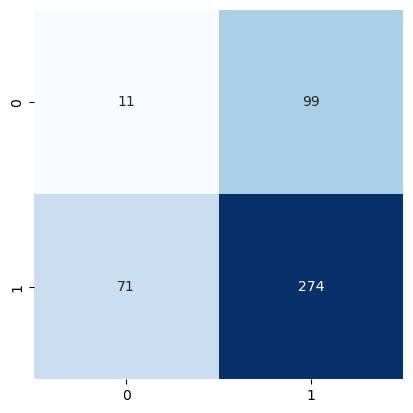

In [ ]:
def predict(single_class_cluster, X_test):
    y_pred = []
    for x in X_test:
        min_d = 10000
        pred = -1
        for c in single_class_cluster:
            d = np.linalg.norm(x - c.centroid)
            if min_d > d:
                min_d = d
                pred = c.label
        y_pred.append(pred)
    return y_pred

y_pred = predict(single_class_cluster, X_test)

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"F-1 score: {f1_score(y_test, y_pred)}")

## Evaluate and features analysis

### Evaluation

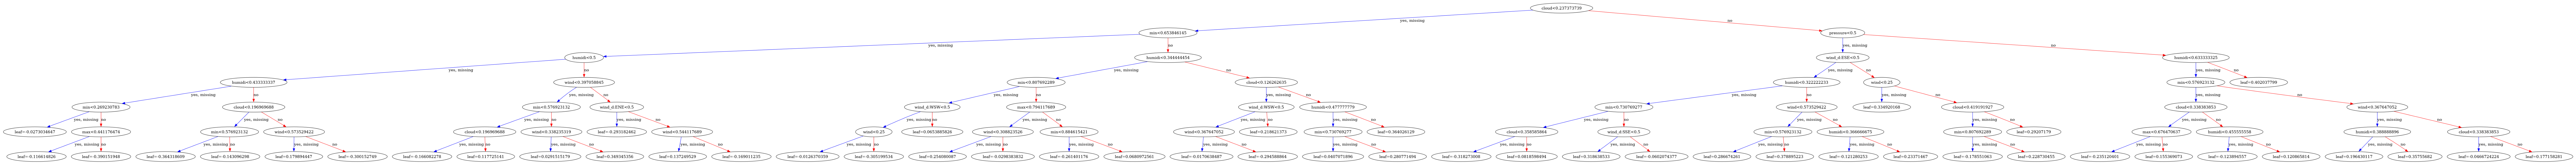

In [ ]:
xgb.plot_tree(model, num_trees=2)
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.savefig("temp.png")

In [ ]:
def softmax(y_pred, threshold=0.5):
    res = []
    for pred in y_pred:
        if pred > threshold:
            res.append(1)
        else:
            res.append(0)
    return res

y_pred = model.predict(dtest_reg)
y_pred = softmax(y_pred, threshold=0.5)

Accuracy score: 0.8681318681318682
F-1 score: 0.9142857142857144


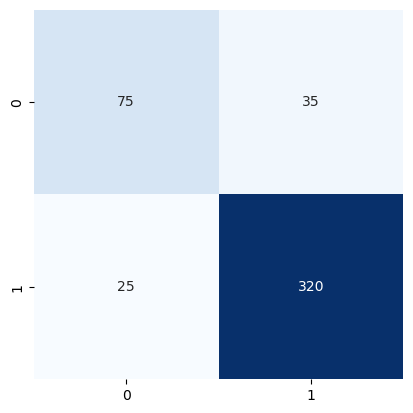

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)


print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"F-1 score: {f1_score(y_test, y_pred)}")

### Features analysis

In [ ]:
# get_feature_name_by_idx()
weights = model.get_score(importance_type='gain')
weights = dict(sorted(weights.items(), key=lambda item: item[1], reverse=True))

for w in list(weights.keys()):
#     print(w)
    print(w + "\t\t" + str(weights[w]))

cloud		10.821521759033203
min		10.110860824584961
humidi		9.623886108398438
pressure		8.899807929992676
wind_d:SW		4.7219343185424805
wind_d:WSW		4.4796271324157715
wind_d:ESE		4.182702541351318
wind_d:W		2.9213719367980957
wind_d:SSW		2.8651134967803955
wind_d:NE		2.734778642654419
wind		2.704523801803589
wind_d:E		2.522759199142456
wind_d:SE		2.0919861793518066
max		2.0202159881591797
wind_d:S		1.8361599445343018
wind_d:SSE		1.693609356880188
wind_d:ENE		1.5171504020690918
wind_d:WNW		0.8920337557792664


In [ ]:
import shap

pred = model.predict(dtest_reg, output_margin=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtest_reg)

for i in range(len(y_pred)):
    if y_pred[i] != y_test[i] and y_test[i] == 0:
        shap_value = shap_values[i]
        n_max_index = sorted(range(len(shap_value)), key=lambda x: shap_value[x])
        for idx in n_max_index:
            print(get_feature_name_by_idx(idx) + " " + str(shap_value[idx]))
        break

/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

humidi -1.3271518
min -0.90628415
wind_d:ESE -0.3308592
wind_d:WSW -0.0688176
wind_d:SW -0.05755794
wind_d:E -0.020698454
wind_d:SSW -0.0025984235
wind_d:WNW -0.0022383267
wind_d:W -0.00073936384
wind_d:N 0.0
wind_d:NNE 0.0
wind_d:NNW 0.0
wind_d:NW 0.0
wind_d:S 0.00010640011
wind_d:SE 0.0038927216
wind_d:ENE 0.010310825
wind_d:NE 0.011300434
wind_d:SSE 0.01157107
pressure 0.017964898
wind 0.03523882
max 0.15242894
cloud 1.4096205
